In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import healpy as hp
from sklearn.model_selection import train_test_split

from set_dataloader import CCD
import time
import pandas as pd
import random
from datasets import MultiSetSequence

In [5]:
with open('../../bricks_data/mini_multiset.pickle', 'rb') as f:
    mini_multiset = pickle.load(f)
    f.close()
df = pd.DataFrame.from_dict(mini_multiset, orient='index')
train_df, test_df = train_test_split(df, test_size=0.33, random_state=44, shuffle=True)

mini_multiset = test_df.to_dict(orient='index')

print(len(mini_multiset))
set = MultiSetSequence()
print(set.input.shape)
print(set.lengths.shape)
set.set_targets('lrg')
print(len(set.target))

print(set.lengths[0])



330
(1000, 64, 30, 9)
(1000, 64)
1000
[ 9  8  8  8  9  8  8  9  8 11  9  9  9 11 11 10  9 10  9 12 12  9  8  8
  9 11 11 11  9  9  8  9 11 11 11 11  9  9  9  8 11 10 11  7  7  8 10 10
 10  8  9 11 11 11  9  8 11  9 10 13 13 13 13  9]


In [80]:
df = pd.DataFrame.from_dict(mini_multiset, orient='index')

pix_train, pix_test= train_test_split(df, test_size=0.33, random_state=44, shuffle=True)
pix_train.head()
pix_test.head()

,0,1,2,3,4
330597,"[[[0.0, 1.0, 130.0, 1.409999966621399, 0.90323...","[14, 14, 14, 10, 10, 7, 14, 14, 14, 10, 14, 14...",30,117,118
259217,"[[[2.0, 1.0, 192.0, 2.0199999809265137, 1.1446...","[13, 13, 10, 13, 13, 13, 13, 13, 10, 10, 6, 6,...",21,66,84
717626,"[[[0.0, 1.0, 90.0, 1.3799999952316284, 1.13284...","[27, 28, 29, 30, 30, 30, 30, 30, 30, 30, 24, 2...",3,30,42
479652,"[[[1.0, 1.0, 40.0, 1.2599999904632568, 0.92971...","[11, 13, 13, 13, 14, 15, 10, 10, 10, 12, 14, 1...",29,67,93
660145,"[[[0.0, 1.0, 90.0, 1.0399999618530273, 1.31294...","[28, 26, 26, 26, 22, 21, 27, 23, 22, 22, 27, 2...",4,11,23


In [ ]:
mini_multiset_tr = pix_train.to_dict(orient='index')
mini_multiset_te = pix_test.to_dict(orient='index')



In [52]:
lrg = pix_train.lrg.to_numpy()
elg = pix_train.elg.to_numpy()
qso = pix_train.qso.to_numpy()
inputs_temp = pix_train.input.to_numpy()
lengths_temp = pix_train.lengths.to_numpy()
num_pixels = len(pix_train)
a = inputs_temp[0].shape
num_subpixels = a[0]
max_ccds = a[1]
num_features = a[2]
input = np.zeros((num_pixels, num_subpixels, max_ccds, num_features))
lengths = np.zeros((num_pixels,num_subpixels), dtype=int)

print(input.shape)
print(lengths.shape)

for i in range(num_pixels):
    input[i] = inputs_temp[i]
    lengths[i] = self.mini_multiset[pix][1]

(670, 64, 30, 9)
(670, 64)


'\n        self.num_features = num_features\n        self.lengths = np.zeros((num_pixels,num_subpixels), dtype=int)\n\n'

In [19]:
# Initialise DataSet
num_pixels = 10
num_features = 7
num_subpixels = 64
max_ccds = 30

keys = list(mini_multiset.keys())

pix_train, pix_test= train_test_split(keys, test_size=0.33, random_state=44, shuffle=True)

print(len(pix_train))

670


#### Experimenting with input sizes

In [2]:
time_start = time.time()

# For DECAM, BASS, MzLS
with open('../../bricks_data/pixel2ccd_2048_non_inclusive.pickle', 'rb') as f:
    subpixel2ccd_dict = pickle.load(f)
    f.close()

time_end = time.time()
time_passed = time_end - time_start
print()
print(f"{time_passed / 60:.5} minutes ({time_passed:.3} seconds) taken to import the dict")
print()


12.409 minutes (7.45e+02 seconds) taken to import the dict



In [3]:
print(len(subpixel2ccd_dict))

28536897


In [4]:
time_start = time.time()

# For DECAM, BASS, MzLS
with open('../../bricks_data/pixel2subpixel_256_2048.pickle', 'rb') as f:
    pixel2subpixel_dict = pickle.load(f)
    f.close()

time_end = time.time()
time_passed = time_end - time_start
print()
print(f"{time_passed / 60:.5} minutes ({time_passed:.3} seconds) taken to import the dict")
print()


0.085275 minutes (5.12 seconds) taken to import the dict



In [52]:
df = pd.read_csv('../../bricks_data/north.csv')


In [53]:
df.head()

,pixel_id,lrg,elg,qso,exposures,stellar,EBV,airmass,ccdskysb_g,ccdskysb_r,ccdskysb_z,exptime_g,exptime_r,exptime_z,meansky_g,meansky_r,meansky_z,seeing_g,seeing_r,seeing_z
0,1672,-0.461533,-0.311995,-0.334279,0.062937,0.092050,0.583346,0.658047,0.818045,0.266036,0.506253,0.779229,0.797941,0.777323,0.020559,0.118533,0.014704,0.135904,0.254894,0.090017
1,1673,-0.546554,-0.295994,-0.308173,0.076923,0.100418,0.616622,0.667571,0.744820,0.214728,0.425562,0.779229,0.927501,0.708501,0.031362,0.270904,0.019868,0.189797,0.176109,0.072230
2,1674,-0.546554,-0.663997,-0.419126,0.069930,0.062762,0.653722,0.681204,0.744614,0.610921,0.528572,0.779229,0.927501,0.707150,0.032851,0.018761,0.012989,0.215572,0.228014,0.107446
3,1675,-0.093108,-0.175993,-0.047106,0.076923,0.075314,0.957369,0.664880,0.772150,0.237818,0.499584,0.667454,0.885217,0.637653,0.027640,0.201572,0.014935,0.220258,0.227551,0.085705
4,1676,-0.206469,-0.471996,-0.406073,0.090909,0.112971,0.964003,0.664818,0.799687,0.261041,0.558536,0.555680,0.842933,0.680172,0.022430,0.136135,0.011760,0.224945,0.263236,0.135835


In [54]:
print(len(df))
lens = np.zeros(len(df)*64)
i = 0
for pix in df.pixel_id:
    subpix = pixel2subpixel_dict[pix]
    for sp in subpix:
        no_ccds = len(subpixel2ccd_dict[sp])
        lens[i] = no_ccds
        i += 1

97537


In [55]:
print("NORTH")

print("Mean CCD's per subpixel:", lens.mean())
print("Max CCD's per subpixel:", lens.max())
print("Min CCD's per subpixel:", lens.min())
print("Pixels in Data:", len(df))
print("SubPixels in Data:", len(lens))
print("Pixel with > 15 CCD's:", (lens > 15).sum())
print("Pixel with > 20 CCD's:", (lens > 20).sum())
print("Pixel with > 25 CCD's:", (lens > 25).sum())
print("Pixel with > 30 CCD's:", (lens > 30).sum())
print("Pixel with > 50 CCD's:", (lens > 50).sum())

print("Pixel with < 1 CCD's:", (lens == 0).sum())


NORTH
Mean CCD's per subpixel: 11.317258130248009
Max CCD's per subpixel: 107.0
Min CCD's per subpixel: 0.0
Pixels in Data: 97537
SubPixels in Data: 6242368
Pixel with > 15 CCD's: 620565
Pixel with > 20 CCD's: 195110
Pixel with > 25 CCD's: 41423
Pixel with > 30 CCD's: 10592
Pixel with > 50 CCD's: 1725
Pixel with < 1 CCD's: 79


In [56]:
df = pd.read_csv('../../bricks_data/south.csv')


In [57]:
df.head()

,pixel_id,lrg,elg,qso,exposures,stellar,EBV,airmass,ccdskysb_g,ccdskysb_r,ccdskysb_z,exptime_g,exptime_r,exptime_z,meansky_g,meansky_r,meansky_z,seeing_g,seeing_r,seeing_z
0,163021,-0.911537,-0.892391,-0.886591,0.248227,0.008403,0.042324,0.050530,0.505040,0.586868,0.495489,0.342857,0.366926,0.290535,8.088033e-10,1.645144e-09,1.358697e-10,0.357084,0.169866,0.222498
1,163022,-0.970512,-0.869332,-0.886591,0.276596,0.021008,0.035700,0.043886,0.486966,0.645731,0.486543,0.275197,0.313718,0.382734,7.831891e-10,1.339398e-09,1.102080e-10,0.340597,0.214987,0.451247
2,163023,-0.852561,-0.846273,-0.855089,0.248227,0.008403,0.037531,0.068436,0.487160,0.631053,0.498875,0.212598,0.311416,0.360186,7.242140e-10,1.227535e-09,1.601562e-10,0.288733,0.254686,0.407574
3,163024,-0.911537,-0.823214,-0.855089,0.290780,0.004202,0.026577,0.099477,0.487161,0.630702,0.535571,0.213255,0.311416,0.360188,7.224710e-10,1.226064e-09,1.405067e-10,0.304782,0.234953,0.426472
4,164044,-0.911537,-0.631055,-0.703877,0.304965,0.037815,0.047397,0.070715,0.513482,0.622137,0.491176,0.364567,0.350094,0.284456,7.877555e-10,1.404464e-09,1.175502e-10,0.381747,0.171378,0.226471


In [58]:
print(len(df))
lens = np.zeros(len(df)*64)
i = 0
for pix in df.pixel_id:
    subpix = pixel2subpixel_dict[pix]
    for sp in subpix:
        no_ccds = len(subpixel2ccd_dict[sp])
        lens[i] = no_ccds
        i += 1

185718


In [59]:
print("SOUTH")

print("Mean CCD's per subpixel:", lens.mean())
print("Max CCD's per subpixel:", lens.max())
print("Min CCD's per subpixel:", lens.min())
print("Pixels in Data:", len(df))
print("SubPixels in Data:", len(lens))
print("Pixel with > 15 CCD's:", (lens > 15).sum())
print("Pixel with > 20 CCD's:", (lens > 20).sum())
print("Pixel with > 25 CCD's:", (lens > 25).sum())
print("Pixel with > 30 CCD's:", (lens > 30).sum())
print("Pixel with > 50 CCD's:", (lens > 50).sum())

print("Pixel with < 1 CCD's:", (lens == 0).sum())

SOUTH
Mean CCD's per subpixel: 10.687213695629934
Max CCD's per subpixel: 88.0
Min CCD's per subpixel: 0.0
Pixels in Data: 185718
SubPixels in Data: 11885952
Pixel with > 15 CCD's: 1083517
Pixel with > 20 CCD's: 211199
Pixel with > 25 CCD's: 32171
Pixel with > 30 CCD's: 3518
Pixel with > 50 CCD's: 67
Pixel with < 1 CCD's: 8976


In [60]:
df = pd.read_csv('../../bricks_data/des.csv')


In [61]:
df.head()

,pixel_id,lrg,elg,qso,exposures,stellar,EBV,airmass,ccdskysb_g,ccdskysb_r,ccdskysb_z,exptime_g,exptime_r,exptime_z,meansky_g,meansky_r,meansky_z,seeing_g,seeing_r,seeing_z
0,346500,-0.111225,0.054066,0.041618,0.000000,0.759690,0.501917,0.787068,0.683502,0.717808,0.601552,0.591789,0.045569,0.902970,3.973393e-11,1.926807e-11,1.716318e-11,0.575469,0.397725,0.859807
1,347525,0.103307,-0.098814,0.083765,0.000000,0.821705,0.518172,0.803865,0.704756,0.710281,0.609899,0.821069,0.093187,1.000000,3.525216e-11,2.176188e-11,1.624611e-11,0.581897,0.414030,0.901885
2,349573,0.225897,-0.066629,0.149995,0.008772,0.705426,0.487686,0.809883,0.682758,0.712073,0.670738,0.591789,0.050894,0.528128,3.870563e-11,1.967882e-11,9.316529e-12,0.594247,0.393132,0.814975
3,350596,-0.080577,-0.066629,-0.024612,0.039474,0.620155,0.508737,0.782988,0.683917,0.718717,0.601217,0.591789,0.045569,0.902970,3.858864e-11,1.921380e-11,1.704449e-11,0.333235,0.448009,0.863042
4,354920,-0.448346,-0.002259,-0.211260,0.078947,0.124031,0.405692,0.773039,0.592356,0.562058,0.535763,0.937258,0.625784,0.995532,7.620004e-11,5.647082e-11,1.195686e-09,0.556086,0.410417,0.754249


In [62]:
print(len(df))
lens = np.zeros(len(df)*64)
i = 0
for pix in df.pixel_id:
    subpix = pixel2subpixel_dict[pix]
    for sp in subpix:
        no_ccds = len(subpixel2ccd_dict[sp])
        lens[i] = no_ccds
        i += 1

86631


In [63]:
print("DES")
print("Mean CCD's per subpixel:", lens.mean())
print("Max CCD's per subpixel:", lens.max())
print("Min CCD's per subpixel:", lens.min())
print("Pixels in Data:", len(df))
print("SubPixels in Data:", len(lens))
print("Pixel with > 15 CCD's:", (lens > 15).sum())
print("Pixel with > 20 CCD's:", (lens > 20).sum())
print("Pixel with > 25 CCD's:", (lens > 25).sum())
print("Pixel with > 30 CCD's:", (lens > 30).sum())
print("Pixel with > 30 CCD's:", (lens > 40).sum())
print("Pixel with > 30 CCD's:", (lens > 45).sum())
print("Pixel with > 50 CCD's:", (lens > 50).sum())

print("Pixel with < 1 CCD's:", (lens == 0).sum())


DES
Mean CCD's per subpixel: 28.277259114808786
Max CCD's per subpixel: 79.0
Min CCD's per subpixel: 0.0
Pixels in Data: 86631
SubPixels in Data: 5544384
Pixel with > 15 CCD's: 5482784
Pixel with > 20 CCD's: 5024032
Pixel with > 25 CCD's: 3548547
Pixel with > 30 CCD's: 1755643
Pixel with > 30 CCD's: 279322
Pixel with > 30 CCD's: 104980
Pixel with > 50 CCD's: 34385
Pixel with < 1 CCD's: 93


Pixels with more than 50 ccds: 133737
Pixels with more than 100 ccds: 39613
Pixels with more than 500 ccds: 31431
Pixels with more than 1000 ccds: 6968


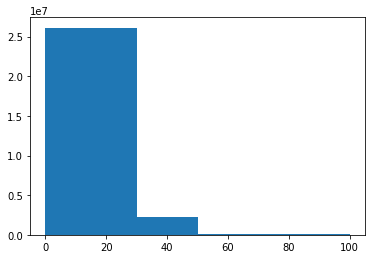

In [6]:
plt.hist(lens, bins=[0, 30, 50, 100])
print("Pixels with more than 50 ccds:", (lens > 50).sum())
print("Pixels with more than 100 ccds:", (lens > 100).sum())
print("Pixels with more than 500 ccds:", (lens > 500).sum())
print("Pixels with more than 1000 ccds:", (lens > 1000).sum())

In [5]:
with open('../../bricks_data/pixel2ccd_256_non_inclusive.pickle', 'rb') as f:
    pixel2ccd_dict = pickle.load(f)
    f.close()

In [8]:
min = 1000
max = 0
aggregate = 0
index_max = 0
lens = np.zeros(len(pixel2ccd_dict))

for i, pix in enumerate(pixel2ccd_dict.keys()):
    no_ccds = len(pixel2ccd_dict[pix])
    lens[i] = no_ccds
    aggregate += no_ccds
    if no_ccds > max:
        max = no_ccds
        index_max = pix
    if no_ccds < min:
        min = no_ccds

print("Mean CCD's per pixel:", lens.mean())
print("Max CCD's per pixel:", max)
print("Min CCD's per pixel:", min)


Mean CCD's per pixel: 14.62690079449568
Max CCD's per pixel: 2951
Min CCD's per pixel: 1


Pixels with more than 50 ccds: 2020
Pixels with more than 100 ccds: 576
Pixels with more than 500 ccds: 462
Pixels with more than 1000 ccds: 102


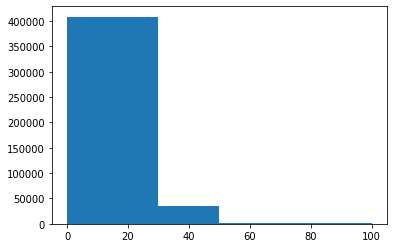

In [9]:
plt.hist(lens, bins=[0, 30, 50, 100])
print("Pixels with more than 50 ccds:", (lens > 50).sum())
print("Pixels with more than 100 ccds:", (lens > 100).sum())
print("Pixels with more than 500 ccds:", (lens > 500).sum())
print("Pixels with more than 1000 ccds:", (lens > 1000).sum())

In [10]:
ccd = CCD()

In [11]:
ra0, dec0, ra1, dec1, ra2, dec2, ra3, dec3 = ccd.get_boundaries()



### Plotting the Pixel - CCD Relationship for the most populated pixel

446195
Number of CCDs that are cutting pixel number  581271 : 2951


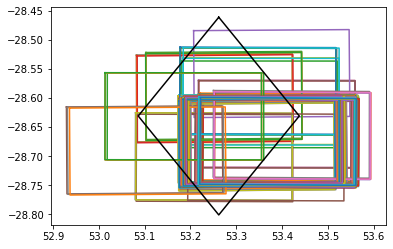

In [12]:
#Validating everything went as intended visually

NSIDE = 256
pixel_number = index_max
print(len(pixel2ccd_dict.keys()))

ccd = pixel2ccd_dict[pixel_number]
print("Number of CCDs that are cutting pixel number ", pixel_number, ":", len(ccd))
for cc in ccd:
    xs = [ra0[cc], ra1[cc], ra2[cc], ra3[cc], ra0[cc]]
    ys = [dec0[cc], dec1[cc], dec2[cc], dec3[cc], dec0[cc]]
    plt.plot(xs, ys)

pixel_boundary = hp.boundaries(nside=NSIDE, pix=pixel_number, step=1)
pixel_boundary_raDec = hp.vec2ang(pixel_boundary.transpose(), lonlat=True)
pixel_boundary_raDec = list(pixel_boundary_raDec)
pixel_boundary_raDec[0] = np.append(pixel_boundary_raDec[0], pixel_boundary_raDec[0][0])
pixel_boundary_raDec[1] = np.append(pixel_boundary_raDec[1], pixel_boundary_raDec[1][0])

plt.plot(pixel_boundary_raDec[0], pixel_boundary_raDec[1], c='black', label="Pixel Boundary")

plt.show()

28536897
Number of CCDs that are cutting pixel number  36803776 : 2951


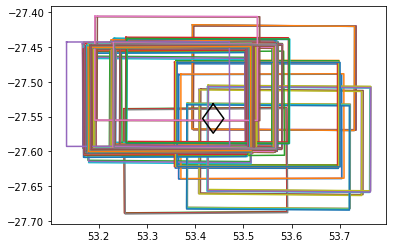

In [13]:
#Validating everything went as intended visually

NSIDE = 2048
pixel_number = index_max_sub
print(len(subpixel2ccd_dict.keys()))

ccd_sub = subpixel2ccd_dict[pixel_number]
print("Number of CCDs that are cutting pixel number ", pixel_number, ":", len(ccd))
for cc in ccd_sub:
    #coord = [[x0,y0], [x1,y1], [x2,y2], [x3,y3], [x0,y0]]
    xs = [ra0[cc], ra1[cc], ra2[cc], ra3[cc], ra0[cc]]
    ys = [dec0[cc], dec1[cc], dec2[cc], dec3[cc], dec0[cc]]
    plt.plot(xs, ys)

pixel_boundary = hp.boundaries(nside=NSIDE, pix=pixel_number, step=1)
pixel_boundary_raDec = hp.vec2ang(pixel_boundary.transpose(), lonlat=True)
pixel_boundary_raDec = list(pixel_boundary_raDec)
pixel_boundary_raDec[0] = np.append(pixel_boundary_raDec[0], pixel_boundary_raDec[0][0])
pixel_boundary_raDec[1] = np.append(pixel_boundary_raDec[1], pixel_boundary_raDec[1][0])

plt.plot(pixel_boundary_raDec[0], pixel_boundary_raDec[1], c='black', label="Pixel Boundary")

plt.show()


## Preparing  Toy MultiSetSequence DataSet to avoid having to load all the massive dicts into the kernel and to avoid swapout

In [12]:
num_pixels = 2
num_subpixels = 4
max_ccds = 5
num_features = 9
#df_raw = pd.read_csv('../../bricks_data/dataset_geometric.csv')
# Randomly Sampling Pixel Indices from Dataframe
#pixel_indices = random.sample(range(len(df_raw)), num_pixels)
pix_ids = [1, 2]
pixel2subpixel_dict = {1: [11, 12, 13, 14], 2: [21, 22, 23, 24]}
subpixel2ccd_dict = {11: [111, 112, 113, 114], 12: [121, 122, 123, 124, 125], 13: [131, 132, 133, 134, 135],
                     14: [141, 142, 143, 144, 145],
                     21: [211, 212, 213, 214, 215], 22: [221, 222], 23: [231, 232, 233, 234, 235],
                     24: [241, 242, 243, 244, 245]}

In [2]:
import importlib
import sys

#importlib.reload(sys.modules['set_dataloader'])
from set_dataloader import CCD

15


In [6]:
ccd = CCD()


6


In [7]:
ccd.num_features


6

In [19]:


num_pixels = 20000
num_subpixels = 64
max_ccds = 30
num_features = ccd.num_features
df_raw = pd.read_csv('../../bricks_data/dataset_geometric.csv')
# Randomly Sampling Pixel Indices from Dataframe
pixel_indices = random.sample(range(len(df_raw)), num_pixels)

df = df_raw.iloc[pixel_indices]
pix_ids = df.pixel_id.to_numpy()

In [20]:
#self.input = -1 * np.ones((self.num_pixels, self.max_ccds, self.num_features))
input = np.zeros((num_pixels, num_subpixels, max_ccds, num_features))
# Iterate through the pixels
print("Pixids", pix_ids)
for pix_no, pix in enumerate(pix_ids):

    subpix_ids = pixel2subpixel_dict[pix]
    subpix_ids = subpix_ids[:num_subpixels]

    for subpix_no, subpix in enumerate(subpix_ids):
        if subpix not in subpixel2ccd_dict:
            continue
        subpix_ccds = subpixel2ccd_dict[subpix]
        random.shuffle(subpix_ccds)
        subpix_ccds = subpix_ccds[:max_ccds]
        x = ccd.get_ccds(subpix_ccds)

        # Iterate through the CCDs for every pixel
        for ccd_no in range(len(subpix_ccds)):
            input[pix_no, subpix_no, ccd_no] = x[ccd_no]

Pixids [708319 317826 186957 ... 709180 252521 251717]


In [21]:
var_set_len = True
lengths = np.zeros((num_pixels, num_subpixels), dtype=int)
print(lengths)
if var_set_len:
    for pix_no, pix in enumerate(pix_ids):
        subpix_ids = pixel2subpixel_dict[pix]
        subpix_ids = subpix_ids[:num_subpixels]

        for subpix_no, subpix in enumerate(subpix_ids):
            if subpix not in subpixel2ccd_dict:
                lengths[pix_no, subpix_no] = 0
                continue
            c = len(subpixel2ccd_dict[subpix])
            if c < max_ccds:
                lengths[pix_no, subpix_no] = c
            else:
                lengths[pix_no, subpix_no] = max_ccds

else:
    lengths.fill(max_ccds)

print(lengths)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[30 30 30 ... 30 30 30]
 [ 7  6  6 ... 10 10 10]
 [13 10 10 ... 13 13  9]
 ...
 [30 30 30 ... 30 25 30]
 [10  8  8 ... 10 10 10]
 [14 14 14 ... 12 12 12]]


In [22]:
print(pix_ids.shape)
print(input.shape)
print(lengths.shape)

(20000,)
(20000, 64, 30, 15)
(20000, 64)


In [23]:
lrg = df.lrg.to_numpy()
elg = df.elg.to_numpy()
qso = df.qso.to_numpy()

stellar = df.stellar.to_numpy()
ebv = df.EBV.to_numpy()
pixel_id = df.pixel_id.to_numpy()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler_in = MinMaxScaler()
stellar = scaler_in.fit_transform(stellar.reshape(-1,1))
ebv = scaler_in.fit_transform(ebv.reshape(-1,1))
stellar = stellar.flatten()
ebv = ebv.flatten()

In [24]:
from collections import defaultdict

mini_multiset = defaultdict(list)
for i, pix in enumerate(pix_ids):
    mini_multiset[pix].append(input[i])
    mini_multiset[pix].append(lengths[i])
    mini_multiset[pix].append(lrg[i])
    mini_multiset[pix].append(elg[i])
    mini_multiset[pix].append(qso[i])
    mini_multiset[pix].append(stellar[i])
    mini_multiset[pix].append(ebv[i])

In [25]:


with open(f'../../bricks_data/multiset.pickle', 'wb') as f:
    pickle.dump(mini_multiset, f)
    f.close()

# Building separate Train, Val and Test Multisets

In [ ]:
# Importing Dicts

In [3]:
time_start = time.time()

# For DECAM, BASS, MzLS
with open('../../bricks_data/pixel2ccd_2048_non_inclusive.pickle', 'rb') as f:
    subpixel2ccd_dict = pickle.load(f)
    f.close()

time_end = time.time()
time_passed = time_end - time_start
print()
print(f"{time_passed / 60:.5} minutes ({time_passed:.3} seconds) taken to import the dict")
print()



13.286 minutes (7.97e+02 seconds) taken to import the dict



In [4]:
time_start = time.time()

# For DECAM, BASS, MzLS
with open('../../bricks_data/pixel2subpixel_256_2048.pickle', 'rb') as f:
    pixel2subpixel_dict = pickle.load(f)
    f.close()

time_end = time.time()
time_passed = time_end - time_start
print()
print(f"{time_passed / 60:.5} minutes ({time_passed:.3} seconds) taken to import the dict")
print()


0.11742 minutes (7.05 seconds) taken to import the dict



In [8]:
ccd = CCD()


6


In [9]:
print(ccd.num_features)

6


In [10]:

df = pd.read_csv('../../bricks_data/north.csv')


num_pixels = len(df)
num_subpixels = 64
max_ccds = 30
num_features = ccd.num_features
# Randomly Sampling Pixel Indices from Dataframe
pix_ids = df.pixel_id.to_numpy()

In [11]:
#self.input = -1 * np.ones((self.num_pixels, self.max_ccds, self.num_features))
input = np.zeros((num_pixels, num_subpixels, max_ccds, num_features))
# Iterate through the pixels
print("Pixids", pix_ids)
for pix_no, pix in enumerate(pix_ids):

    subpix_ids = pixel2subpixel_dict[pix]
    subpix_ids = subpix_ids[:num_subpixels]

    for subpix_no, subpix in enumerate(subpix_ids):
        if subpix not in subpixel2ccd_dict:
            continue
        subpix_ccds = subpixel2ccd_dict[subpix]
        random.shuffle(subpix_ccds)
        subpix_ccds = subpix_ccds[:max_ccds]
        x = ccd.get_ccds(subpix_ccds)

        # Iterate through the CCDs for every pixel
        for ccd_no in range(len(subpix_ccds)):
            input[pix_no, subpix_no, ccd_no] = x[ccd_no]

Pixids [ 62102  47512 138135 ...   8247  76030 142465]


In [12]:
var_set_len = True
lengths = np.zeros((num_pixels, num_subpixels), dtype=int)
print(lengths)
if var_set_len:
    for pix_no, pix in enumerate(pix_ids):
        subpix_ids = pixel2subpixel_dict[pix]
        subpix_ids = subpix_ids[:num_subpixels]

        for subpix_no, subpix in enumerate(subpix_ids):
            if subpix not in subpixel2ccd_dict:
                lengths[pix_no, subpix_no] = 0
                continue
            c = len(subpixel2ccd_dict[subpix])
            if c < max_ccds:
                lengths[pix_no, subpix_no] = c
            else:
                lengths[pix_no, subpix_no] = max_ccds

else:
    lengths.fill(max_ccds)

print(lengths)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[ 9  7  8 ... 11 11 13]
 [12 12 12 ... 12 12 14]
 [10  7 10 ...  9 12 11]
 ...
 [11  9 11 ... 14 14 14]
 [12 11 11 ... 11  9  9]
 [12 13 12 ... 14 13 10]]


In [13]:
print(pix_ids.shape)
print(input.shape)
print(lengths.shape)

(78029,)
(78029, 64, 30, 6)
(78029, 64)


In [14]:
lrg = df.lrg.to_numpy()
elg = df.elg.to_numpy()
qso = df.qso.to_numpy()

stellar = df.stellar.to_numpy()
ebv = df.EBV.to_numpy()
pixel_id = df.pixel_id.to_numpy()
stellar = stellar.flatten()
ebv = ebv.flatten()

In [15]:
from collections import defaultdict

mini_multiset = defaultdict(list)
for i, pix in enumerate(pix_ids):
    if i % 2000 == 0:
        print(i)
    mini_multiset[pix].append(input[i])
    mini_multiset[pix].append(lengths[i])
    mini_multiset[pix].append(lrg[i])
    mini_multiset[pix].append(elg[i])
    mini_multiset[pix].append(qso[i])
    mini_multiset[pix].append(stellar[i])
    mini_multiset[pix].append(ebv[i])


0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000
38000
40000
42000
44000
46000
48000
50000
52000
54000
56000
58000
60000
62000
64000
66000
68000
70000
72000
74000
76000
78000


In [16]:
with open(f'/Volumes/Astrodisk/bricks_data/north.pickle', 'wb') as f:
    pickle.dump(mini_multiset, f)
    f.close()

In [17]:

df = pd.read_csv('../../bricks_data/north_test.csv')


num_pixels = len(df)
num_subpixels = 64
max_ccds = 30
num_features = ccd.num_features
# Randomly Sampling Pixel Indices from Dataframe
pix_ids = df.pixel_id.to_numpy()

In [18]:
#self.input = -1 * np.ones((self.num_pixels, self.max_ccds, self.num_features))
input = np.zeros((num_pixels, num_subpixels, max_ccds, num_features))
# Iterate through the pixels
print("Pixids", pix_ids)
for pix_no, pix in enumerate(pix_ids):

    subpix_ids = pixel2subpixel_dict[pix]
    subpix_ids = subpix_ids[:num_subpixels]

    for subpix_no, subpix in enumerate(subpix_ids):
        if subpix not in subpixel2ccd_dict:
            continue
        subpix_ccds = subpixel2ccd_dict[subpix]
        random.shuffle(subpix_ccds)
        subpix_ccds = subpix_ccds[:max_ccds]
        x = ccd.get_ccds(subpix_ccds)

        # Iterate through the CCDs for every pixel
        for ccd_no in range(len(subpix_ccds)):
            input[pix_no, subpix_no, ccd_no] = x[ccd_no]

Pixids [ 20930 128915  22899 ... 147555 158690 176047]


In [19]:
var_set_len = True
lengths = np.zeros((num_pixels, num_subpixels), dtype=int)
print(lengths)
if var_set_len:
    for pix_no, pix in enumerate(pix_ids):
        subpix_ids = pixel2subpixel_dict[pix]
        subpix_ids = subpix_ids[:num_subpixels]

        for subpix_no, subpix in enumerate(subpix_ids):
            if subpix not in subpixel2ccd_dict:
                lengths[pix_no, subpix_no] = 0
                continue
            c = len(subpixel2ccd_dict[subpix])
            if c < max_ccds:
                lengths[pix_no, subpix_no] = c
            else:
                lengths[pix_no, subpix_no] = max_ccds

else:
    lengths.fill(max_ccds)

print(lengths)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[12 12 14 ... 11 10 11]
 [14 13 14 ...  9 11 12]
 [13 12 12 ... 10 11 11]
 ...
 [23 10 12 ... 21 23 19]
 [ 9  5  8 ...  7  9 11]
 [16 18 16 ... 21 21 16]]


In [20]:
print(pix_ids.shape)
print(input.shape)
print(lengths.shape)

(19508,)
(19508, 64, 30, 6)
(19508, 64)


In [21]:
lrg = df.lrg.to_numpy()
elg = df.elg.to_numpy()
qso = df.qso.to_numpy()

stellar = df.stellar.to_numpy()
ebv = df.EBV.to_numpy()
pixel_id = df.pixel_id.to_numpy()
stellar = stellar.flatten()
ebv = ebv.flatten()

In [22]:
from collections import defaultdict

mini_multiset = defaultdict(list)
for i, pix in enumerate(pix_ids):
    if i % 2000 == 0:
        print(i)
    mini_multiset[pix].append(input[i])
    mini_multiset[pix].append(lengths[i])
    mini_multiset[pix].append(lrg[i])
    mini_multiset[pix].append(elg[i])
    mini_multiset[pix].append(qso[i])
    mini_multiset[pix].append(stellar[i])
    mini_multiset[pix].append(ebv[i])
    mini_multiset[pix].append(pix)


0
2000
4000
6000
8000
10000
12000
14000
16000
18000


In [23]:
with open(f'/Volumes/Astrodisk/bricks_data/north_test.pickle', 'wb') as f:
    pickle.dump(mini_multiset, f)
    f.close()

In [24]:
df = pd.read_csv('../../bricks_data/south.csv')


num_pixels = len(df)
num_subpixels = 64
max_ccds = 25
num_features = ccd.num_features
# Randomly Sampling Pixel Indices from Dataframe
pix_ids = df.pixel_id.to_numpy()

In [25]:
#self.input = -1 * np.ones((self.num_pixels, self.max_ccds, self.num_features))
input = np.zeros((num_pixels, num_subpixels, max_ccds, num_features))
# Iterate through the pixels
print("Pixids", pix_ids)
for pix_no, pix in enumerate(pix_ids):

    subpix_ids = pixel2subpixel_dict[pix]
    subpix_ids = subpix_ids[:num_subpixels]

    for subpix_no, subpix in enumerate(subpix_ids):
        if subpix not in subpixel2ccd_dict:
            continue
        subpix_ccds = subpixel2ccd_dict[subpix]
        random.shuffle(subpix_ccds)
        subpix_ccds = subpix_ccds[:max_ccds]
        x = ccd.get_ccds(subpix_ccds)

        # Iterate through the CCDs for every pixel
        for ccd_no in range(len(subpix_ccds)):
            input[pix_no, subpix_no, ccd_no] = x[ccd_no]

Pixids [244761 259578 231471 ... 363513 234915 287695]


In [26]:
var_set_len = True
lengths = np.zeros((num_pixels, num_subpixels), dtype=int)
print(lengths)
if var_set_len:
    for pix_no, pix in enumerate(pix_ids):
        subpix_ids = pixel2subpixel_dict[pix]
        subpix_ids = subpix_ids[:num_subpixels]

        for subpix_no, subpix in enumerate(subpix_ids):
            if subpix not in subpixel2ccd_dict:
                lengths[pix_no, subpix_no] = 0
                continue
            c = len(subpixel2ccd_dict[subpix])
            if c < max_ccds:
                lengths[pix_no, subpix_no] = c
            else:
                lengths[pix_no, subpix_no] = max_ccds

else:
    lengths.fill(max_ccds)

print(lengths)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[ 9  6  6 ...  8 11  9]
 [ 9  9  9 ...  9  9  6]
 [ 9 13 13 ...  9  9  3]
 ...
 [10 10 10 ... 10 10 13]
 [10  8  8 ... 14 14 14]
 [15 12 12 ... 15 15 10]]


In [27]:
print(pix_ids.shape)
print(input.shape)
print(lengths.shape)

(148574,)
(148574, 64, 25, 6)
(148574, 64)


In [28]:
lrg = df.lrg.to_numpy()
elg = df.elg.to_numpy()
qso = df.qso.to_numpy()

stellar = df.stellar.to_numpy()
ebv = df.EBV.to_numpy()
pixel_id = df.pixel_id.to_numpy()
stellar = stellar.flatten()
ebv = ebv.flatten()

In [29]:
from collections import defaultdict

mini_multiset = defaultdict(list)
for i, pix in enumerate(pix_ids):
    if i % 2000 == 0:
        print(i)
    mini_multiset[pix].append(input[i])
    mini_multiset[pix].append(lengths[i])
    mini_multiset[pix].append(lrg[i])
    mini_multiset[pix].append(elg[i])
    mini_multiset[pix].append(qso[i])
    mini_multiset[pix].append(stellar[i])
    mini_multiset[pix].append(ebv[i])


0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000
38000
40000
42000
44000
46000
48000
50000
52000
54000
56000
58000
60000
62000
64000
66000
68000
70000
72000
74000
76000
78000
80000
82000
84000
86000
88000
90000
92000
94000
96000
98000
100000
102000
104000
106000
108000
110000
112000
114000
116000
118000
120000
122000
124000
126000
128000
130000
132000
134000
136000
138000
140000
142000
144000
146000
148000


In [30]:
with open(f'/Volumes/Astrodisk/bricks_data/south.pickle', 'wb') as f:
    pickle.dump(mini_multiset, f)
    f.close()

In [31]:
df = pd.read_csv('../../bricks_data/south_test.csv')


num_pixels = len(df)
num_subpixels = 64
max_ccds = 25
num_features = ccd.num_features
# Randomly Sampling Pixel Indices from Dataframe
pix_ids = df.pixel_id.to_numpy()

In [32]:
#self.input = -1 * np.ones((self.num_pixels, self.max_ccds, self.num_features))
input = np.zeros((num_pixels, num_subpixels, max_ccds, num_features))
# Iterate through the pixels
print("Pixids", pix_ids)
for pix_no, pix in enumerate(pix_ids):

    subpix_ids = pixel2subpixel_dict[pix]
    subpix_ids = subpix_ids[:num_subpixels]

    for subpix_no, subpix in enumerate(subpix_ids):
        if subpix not in subpixel2ccd_dict:
            continue
        subpix_ccds = subpixel2ccd_dict[subpix]
        random.shuffle(subpix_ccds)
        subpix_ccds = subpix_ccds[:max_ccds]
        x = ccd.get_ccds(subpix_ccds)

        # Iterate through the CCDs for every pixel
        for ccd_no in range(len(subpix_ccds)):
            input[pix_no, subpix_no, ccd_no] = x[ccd_no]

Pixids [301589 357501 219584 ... 200592 237037 379880]


In [33]:
var_set_len = True
lengths = np.zeros((num_pixels, num_subpixels), dtype=int)
print(lengths)
if var_set_len:
    for pix_no, pix in enumerate(pix_ids):
        subpix_ids = pixel2subpixel_dict[pix]
        subpix_ids = subpix_ids[:num_subpixels]

        for subpix_no, subpix in enumerate(subpix_ids):
            if subpix not in subpixel2ccd_dict:
                lengths[pix_no, subpix_no] = 0
                continue
            c = len(subpixel2ccd_dict[subpix])
            if c < max_ccds:
                lengths[pix_no, subpix_no] = c
            else:
                lengths[pix_no, subpix_no] = max_ccds

else:
    lengths.fill(max_ccds)

print(lengths)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[14 17 20 ... 12 12 12]
 [ 6  3  6 ...  6  6  9]
 [ 9  9  9 ...  7  4  9]
 ...
 [11 14 14 ... 13 13  9]
 [11 12 16 ... 14 14  9]
 [16 12 12 ... 13 13 14]]


In [34]:
print(pix_ids.shape)
print(input.shape)
print(lengths.shape)

(37144,)
(37144, 64, 25, 6)
(37144, 64)


In [35]:
lrg = df.lrg.to_numpy()
elg = df.elg.to_numpy()
qso = df.qso.to_numpy()

stellar = df.stellar.to_numpy()
ebv = df.EBV.to_numpy()
pixel_id = df.pixel_id.to_numpy()
stellar = stellar.flatten()
ebv = ebv.flatten()

In [36]:
from collections import defaultdict

mini_multiset = defaultdict(list)
for i, pix in enumerate(pix_ids):
    if i % 2000 == 0:
        print(i)
    mini_multiset[pix].append(input[i])
    mini_multiset[pix].append(lengths[i])
    mini_multiset[pix].append(lrg[i])
    mini_multiset[pix].append(elg[i])
    mini_multiset[pix].append(qso[i])
    mini_multiset[pix].append(stellar[i])
    mini_multiset[pix].append(ebv[i])
    mini_multiset[pix].append(pix)


0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000


In [37]:
with open(f'/Volumes/Astrodisk/bricks_data/south_test.pickle', 'wb') as f:
    pickle.dump(mini_multiset, f)
    f.close()

In [38]:
df = pd.read_csv('../../bricks_data/des.csv')


num_pixels = len(df)
num_subpixels = 64
max_ccds = 50
num_features = ccd.num_features
# Randomly Sampling Pixel Indices from Dataframe
pix_ids = df.pixel_id.to_numpy()

In [39]:
#self.input = -1 * np.ones((self.num_pixels, self.max_ccds, self.num_features))
input = np.zeros((num_pixels, num_subpixels, max_ccds, num_features))
# Iterate through the pixels
print("Pixids", pix_ids)
for pix_no, pix in enumerate(pix_ids):

    subpix_ids = pixel2subpixel_dict[pix]
    subpix_ids = subpix_ids[:num_subpixels]

    for subpix_no, subpix in enumerate(subpix_ids):
        if subpix not in subpixel2ccd_dict:
            continue
        subpix_ccds = subpixel2ccd_dict[subpix]
        random.shuffle(subpix_ccds)
        subpix_ccds = subpix_ccds[:max_ccds]
        x = ccd.get_ccds(subpix_ccds)

        # Iterate through the CCDs for every pixel
        for ccd_no in range(len(subpix_ccds)):
            input[pix_no, subpix_no, ccd_no] = x[ccd_no]

Pixids [681935 741640 704406 ... 381430 606767 713029]


In [40]:
var_set_len = True
lengths = np.zeros((num_pixels, num_subpixels), dtype=int)
print(lengths)
if var_set_len:
    for pix_no, pix in enumerate(pix_ids):
        subpix_ids = pixel2subpixel_dict[pix]
        subpix_ids = subpix_ids[:num_subpixels]

        for subpix_no, subpix in enumerate(subpix_ids):
            if subpix not in subpixel2ccd_dict:
                lengths[pix_no, subpix_no] = 0
                continue
            c = len(subpixel2ccd_dict[subpix])
            if c < max_ccds:
                lengths[pix_no, subpix_no] = c
            else:
                lengths[pix_no, subpix_no] = max_ccds

else:
    lengths.fill(max_ccds)

print(lengths)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[44 43 43 ... 48 48 46]
 [25 38 39 ... 37 37 27]
 [28 24 26 ... 26 25 22]
 ...
 [15 18 18 ... 24 24 16]
 [20 27 24 ... 27 27 25]
 [18 27 27 ... 30 27 21]]


In [41]:
print(pix_ids.shape)
print(input.shape)
print(lengths.shape)

(69304,)
(69304, 64, 50, 6)
(69304, 64)


In [42]:
lrg = df.lrg.to_numpy()
elg = df.elg.to_numpy()
qso = df.qso.to_numpy()

stellar = df.stellar.to_numpy()
ebv = df.EBV.to_numpy()
pixel_id = df.pixel_id.to_numpy()
stellar = stellar.flatten()
ebv = ebv.flatten()

In [43]:
from collections import defaultdict

mini_multiset = defaultdict(list)
for i, pix in enumerate(pix_ids):
    if i % 2000 == 0:
        print(i)
    mini_multiset[pix].append(input[i])
    mini_multiset[pix].append(lengths[i])
    mini_multiset[pix].append(lrg[i])
    mini_multiset[pix].append(elg[i])
    mini_multiset[pix].append(qso[i])
    mini_multiset[pix].append(stellar[i])
    mini_multiset[pix].append(ebv[i])


0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000
38000
40000
42000
44000
46000
48000
50000
52000
54000
56000
58000
60000
62000
64000
66000
68000


In [44]:
with open(f'/Volumes/Astrodisk/bricks_data/des.pickle', 'wb') as f:
    pickle.dump(mini_multiset, f)
    f.close()

In [45]:
df = pd.read_csv('../../bricks_data/des_test.csv')


num_pixels = len(df)
num_subpixels = 64
max_ccds = 50
num_features = ccd.num_features
# Randomly Sampling Pixel Indices from Dataframe
pix_ids = df.pixel_id.to_numpy()

In [46]:
#self.input = -1 * np.ones((self.num_pixels, self.max_ccds, self.num_features))
input = np.zeros((num_pixels, num_subpixels, max_ccds, num_features))
# Iterate through the pixels
print("Pixids", pix_ids)
for pix_no, pix in enumerate(pix_ids):

    subpix_ids = pixel2subpixel_dict[pix]
    subpix_ids = subpix_ids[:num_subpixels]

    for subpix_no, subpix in enumerate(subpix_ids):
        if subpix not in subpixel2ccd_dict:
            continue
        subpix_ccds = subpixel2ccd_dict[subpix]
        random.shuffle(subpix_ccds)
        subpix_ccds = subpix_ccds[:max_ccds]
        x = ccd.get_ccds(subpix_ccds)

        # Iterate through the CCDs for every pixel
        for ccd_no in range(len(subpix_ccds)):
            input[pix_no, subpix_no, ccd_no] = x[ccd_no]

Pixids [400965 689172 692796 ... 504470 708440 722696]


In [47]:
var_set_len = True
lengths = np.zeros((num_pixels, num_subpixels), dtype=int)
print(lengths)
if var_set_len:
    for pix_no, pix in enumerate(pix_ids):
        subpix_ids = pixel2subpixel_dict[pix]
        subpix_ids = subpix_ids[:num_subpixels]

        for subpix_no, subpix in enumerate(subpix_ids):
            if subpix not in subpixel2ccd_dict:
                lengths[pix_no, subpix_no] = 0
                continue
            c = len(subpixel2ccd_dict[subpix])
            if c < max_ccds:
                lengths[pix_no, subpix_no] = c
            else:
                lengths[pix_no, subpix_no] = max_ccds

else:
    lengths.fill(max_ccds)

print(lengths)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[20 24 21 ... 29 29 23]
 [34 38 38 ... 31 32 30]
 [21 23 23 ... 14  9 23]
 ...
 [24 27 28 ... 29 31 33]
 [35 33 32 ... 28 29 27]
 [38 38 35 ... 35 37 38]]


In [48]:
print(pix_ids.shape)
print(input.shape)
print(lengths.shape)

(17327,)
(17327, 64, 50, 6)
(17327, 64)


In [49]:
lrg = df.lrg.to_numpy()
elg = df.elg.to_numpy()
qso = df.qso.to_numpy()

stellar = df.stellar.to_numpy()
ebv = df.EBV.to_numpy()
pixel_id = df.pixel_id.to_numpy()
stellar = stellar.flatten()
ebv = ebv.flatten()

In [50]:
from collections import defaultdict

mini_multiset = defaultdict(list)
for i, pix in enumerate(pix_ids):
    if i % 2000 == 0:
        print(i)
    mini_multiset[pix].append(input[i])
    mini_multiset[pix].append(lengths[i])
    mini_multiset[pix].append(lrg[i])
    mini_multiset[pix].append(elg[i])
    mini_multiset[pix].append(qso[i])
    mini_multiset[pix].append(stellar[i])
    mini_multiset[pix].append(ebv[i])
    mini_multiset[pix].append(pix)



0
2000
4000
6000
8000
10000
12000
14000
16000


In [51]:
with open(f'/Volumes/Astrodisk/bricks_data/des_test.pickle', 'wb') as f:
    pickle.dump(mini_multiset, f)
    f.close()